### Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import math
import seaborn as sns

# Import Custom Module
import OeconToolbox as ott
import LoanPortfolioTool as pft

%load_ext autoreload
%autoreload 2
%matplotlib inline

### [OPTIONAL] Set Matplotlib Style

In [3]:
matplotlib.style.use('default')

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 10})
matplotlib.path.should_simplify = True

sns.set_style("ticks")

cm = 1/2.54
textwidth = 13.998 / 2.54

## Import Cumulative Default Table

In [4]:
DefTable = pd.read_excel("CumulativeDefaultTable.xlsx",header=[0],index_col=[0],skipfooter=5,usecols="A:K")
DefTable.round(2)

,1,2,3,4,5,6,7,8,9,10
AAA,0.00,0.03,0.10,0.19,0.27,0.37,0.41,0.46,0.52,0.58
AA,0.02,0.06,0.11,0.21,0.30,0.41,0.49,0.56,0.63,0.70
A,0.05,0.13,0.22,0.33,0.46,0.60,0.76,0.90,1.05,1.20
BBB,0.16,0.43,0.75,1.14,1.54,1.94,2.27,2.61,2.94,3.24
BB,0.63,1.93,3.46,4.99,6.43,7.75,8.89,9.90,10.82,11.64
B,3.34,7.80,11.75,14.89,17.35,19.36,20.99,22.31,23.50,24.62


# Simulating a Portfolio of loans
The SPV portfolio consists of $J$ loans from identical corporate issuers with a single class of debt outstanding. The parameters of the issuers is identical to those described in the 'Collateral Dynamics.ipynb' notebook.

## Parameters of the Corporate Issuers

In [5]:
V0 = 100      # Initial Asset Value
rf = .035     # Risk-Free Rate
rm = .105     # Market Return
beta = .8     # Firm CAPM Coefficient
sigma_i = .25 # Idiosyncratic Risk
sigma_m = .14 # Market Risk
ttm = 5       # Time to Maturity of Debt
penalty = 0   # Penalty on prepayment

Auxiliary Calculations

In [6]:
mu = rf + beta * (rm - rf)
sigma = ott.sigma_beta_adj(beta, sigma_m, sigma_i)
face_value = ott.facevalue_from_probability(DefTable.loc["B", ttm] / 100, V0, ttm, mu, sigma)
market_value = ott.mv_bond(V0, face_value, ttm, rf, sigma)
b_loan_yield = ott.zero_yield(market_value,face_value, ttm)
# Results from Collateral Dynamics Notebook
mv_call = 54.71780723807047
b_callable_yield = ott.zero_yield(mv_call,face_value, ttm)

## Parameters of the SPV

In [7]:
J = 125    # number of loans
N = 250000 # Number of simulated portfolios

# Modelling the SPV Dynamics without Prepayment on Collateral Assets

In [8]:
max_spv_cash_flows = face_value * J
initial_market_value = market_value * J
print("The absolute maximum payoff: {0:0.2f} with initial market value: {1:0.2f}".format(max_spv_cash_flows,initial_market_value))

The absolute maximum payoff: 9180.30 with initial market value: 6990.38


# SPV with Prepayments in Collateral

In [22]:
pf = Loan_Portfolios(V = V0, B = face_value, T = ttm, rf = rf, beta = beta, sigmaM = sigma_m, sigmaI = sigma_i,j=J,n=N,seed=1234)

In [11]:
SPV_Q, _ = pf.no_prepayments(risk_neutral = True, paths = False)

In [12]:
SPV_P, M = pf.no_prepayments(risk_neutral = False, paths = False)

In [13]:
100 * np.quantile(SPV_P, DefTable.loc['A',ttm]/100) / (SPV_Q.mean() * np.exp(-rf*ttm))

105.73335266305533

In [23]:
SPV_P_pp, M, distributions = pf.with_prepayments(default_table=DefTable,rating='B',mv_callable=mv_call, risk_neutral = False, paths = False, penalty = 0)

In [33]:
SPV_P_pp

array([4827.13457142, 4834.48712997, 5188.10347638, ..., 8738.48399786,
       8739.04585962, 8745.10898305])

In [32]:
M

array([-10.45804969,  -8.84181808, -10.03537062, ...,   9.03923267,
         7.3207617 ,   7.44957599])

In [31]:
distributions

array([ 97.12962129, 157.42243283, 110.11126839, ..., 188.02069435,
       203.53641758, 196.13650002])

In [38]:
tmp, tranches_pp = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    tmp[i]  = np.quantile(SPV_P_pp, def_prob/100)
    if i == 0 : tranches_pp[i] = np.quantile(SPV_P_pp, def_prob/100)
    else: tranches_pp[i] = np.quantile(SPV_P_pp, def_prob/100) - tmp[i-1].sum(axis=0)
    i = i + 1
tranches_pp[i] = np.quantile(SPV_P_pp, 1) - tmp[i-1].sum(axis=0)

In [39]:
tranches_pp

array([6752.56162935,   31.2153885 ,  115.3956283 ,  336.20343599,
        411.26578818,  296.57616819,  801.89094453])

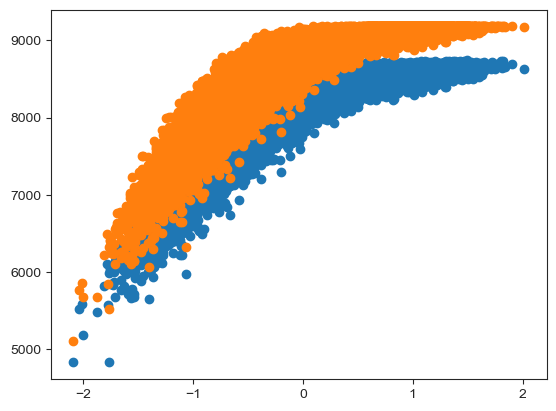

In [36]:
plt.scatter(M/5,SPV_P_pp)
plt.scatter(M/5,SPV_P)

In [86]:
pd.DataFrame(nc_loan_paths[:,1,:]).T.head()

,0,1,2,3,4,5
0,55.923057,60.405143,63.465637,68.208353,70.835403,73.442399
1,55.923057,56.707179,65.134331,62.724851,66.209126,59.391516
2,55.923057,52.819171,62.822462,66.679022,70.831822,73.442399
3,55.923057,56.573820,62.031438,61.660553,64.148838,73.442399
4,55.923057,52.714125,62.326489,65.946027,54.466777,39.856744


In [87]:
pd.DataFrame(call_mat[:,1,:]).T.head()

,0,1,2,3,4,5
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [134]:
terminal_value = a_paths[-1,:,:]
cash_flows = np.minimum(terminal_value, face_values_mat).sum(axis=1)
sort = cash_flows.argsort()


In [89]:
pd.DataFrame(asset_paths_Q[:,1,:]).T

NameError: name 'asset_paths_Q' is not defined

In [149]:
pd.DataFrame(a_paths[:,1,:]).T

,0,1,2,3,4,5
0,100.0,100.000000,99.020532,134.898791,119.339187,72.936384
1,100.0,87.037896,100.000000,58.037310,55.327669,41.526427
2,100.0,71.680167,100.000000,103.626791,127.447245,88.266776
3,100.0,86.379505,99.403918,78.996494,73.183168,80.566302
4,100.0,71.347002,101.650117,100.000000,55.343407,39.101567
...,...,...,...,...,...,...
120,100.0,100.000000,113.317619,103.909984,100.664211,80.345663
121,100.0,83.539730,96.389022,91.068572,100.000000,83.820109
122,100.0,100.000000,128.434660,171.902514,196.141832,240.752193
123,100.0,57.548371,54.686841,70.699744,71.515739,54.460422


In [148]:
pd.DataFrame(call_mat[:,1,:]).T

,0,1,2,3,4,5
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
120,0.0,1.0,0.0,0.0,0.0,0.0
121,0.0,0.0,0.0,0.0,1.0,0.0
122,0.0,1.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,1.0


In [135]:
pp_SPV_Q = cash_flows[sort]

In [47]:
pp_SPV_P = cash_flows[sort]
pp_M = random[1:,:,0].sum(axis=0)[sort]

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 5.0000e+00, 6.0000e+00, 1.1000e+01,
        1.0000e+01, 1.6000e+01, 1.9000e+01, 2.2000e+01, 2.4000e+01,
        3.5000e+01, 5.0000e+01, 5.8000e+01, 8.6000e+01, 1.2600e+02,
        1.7800e+02, 1.9300e+02, 2.8500e+02, 3.5400e+02, 5.0800e+02,
        6.0900e+02, 8.2100e+02, 1.0720e+03, 1.3480e+03, 1.7780e+03,
        2.2700e+03, 2.9360e+03, 3.7500e+03, 4.8200e+03, 6.2280e+03,
        8.0110e+03, 1.0386e+04, 1.3098e+04, 1.6671e+04, 2.0706e+04,
        2.5624e+04, 3.1110e+04, 3.5610e+04, 3.6306e+04, 2.4852e+04]),
 array([0.55596096, 0.56484174, 0.57372252, 0.5826033 , 0.59148408,
        0.60036486, 0.60924564, 0.61812642, 0.62700721, 0.63588799,
        0.64476877, 0.65364955, 0.66253033, 0.67141111, 0.68029189,
        0.68917267, 0.69805345, 0.70693423, 0.71581501, 0.72469579,
        0.73357658, 0.74245736, 0.75133814, 0.

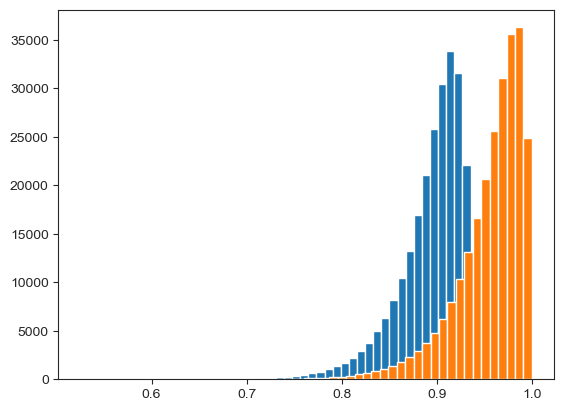

In [96]:
plt.hist(pp_SPV_P/max_spv_cash_flows,bins=50)
plt.hist(SPV_P/max_spv_cash_flows,bins=50)
            

In [97]:
tmp, tranches_pp = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    tmp[i]  = np.quantile(pp_SPV_P, def_prob/100)
    if i == 0 : tranches_pp[i] = np.quantile(pp_SPV_P, def_prob/100)
    else: tranches_pp[i] = np.quantile(pp_SPV_P, def_prob/100) - tmp[i-1].sum(axis=0)
    i = i + 1
tranches_pp[i] = np.quantile(pp_SPV_P, 1) - tmp[i-1].sum(axis=0)

In [98]:
tranches_pp

array([6752.56162935,   31.2153885 ,  115.3956283 ,  336.20343599,
        411.26578818,  296.57616819,  801.89094453])

In [99]:
tranches

array([7233.12392595,   32.55366926,  125.58519927,  358.08993904,
        442.005521  ,  317.878967  ,  671.06262338])

# Cash Flows to each Tranche

In [100]:
pd.DataFrame({'Cash Flows':tranches_pp,'Sum':tranches_pp.cumsum()},["AAA","AA","A","BBB","BB","B","Equity"])

,Cash Flows,Sum
AAA,6752.561629,6752.561629
AA,31.215389,6783.777018
A,115.395628,6899.172646
BBB,336.203436,7235.376082
BB,411.265788,7646.641870
B,296.576168,7943.218039
Equity,801.890945,8745.108983


In [101]:
pd.DataFrame({'Cash Flows':tranches,'Sum':tranches.cumsum()},["AAA","AA","A","BBB","BB","B","Equity"])

,Cash Flows,Sum
AAA,7233.123926,7233.123926
AA,32.553669,7265.677595
A,125.585199,7391.262794
BBB,358.089939,7749.352734
BB,442.005521,8191.358255
B,317.878967,8509.237222
Equity,671.062623,9180.299845


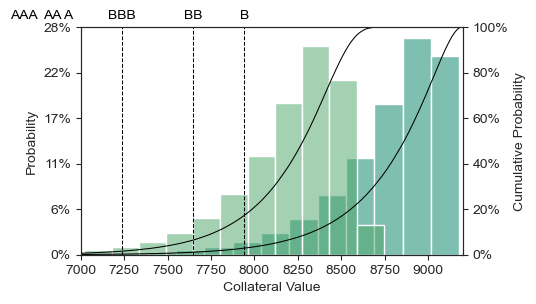

In [102]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P
simulations_pp = pp_SPV_P

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=0.5)
ax = sns.histplot(data=simulations_pp, bins=25, color=palette(75), stat='probability', alpha=0.5)

plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations_pp, def_prob/100)
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
ax2 = sns.ecdfplot(data=simulations_pp, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()

#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [103]:
pp_SPV_P_small = np.random.RandomState(1234).choice(pp_SPV_P,size=2500)
pp_M_small = np.random.RandomState(1234).choice(pp_M,size=2500)

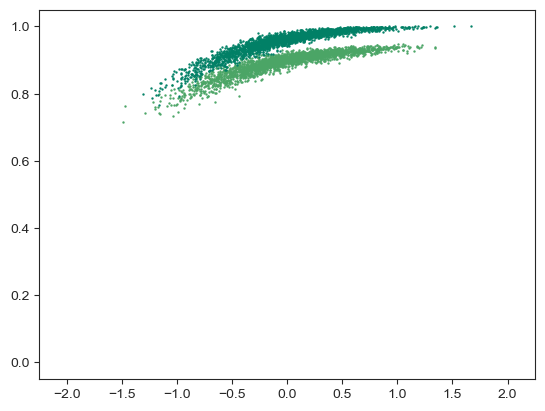

In [104]:
plt.scatter(x=pp_M_small/ttm, y = pp_SPV_P_small/max_spv_cash_flows, s = 0.5, color=palette(75))
plt.scatter(x=scatter_data['Market Factor'], y = scatter_data['SPV'], s = 0.5, color=palette(1))
plt.ylim([-0.05,1.05])
plt.xlim([-2.25,2.25])
plt.savefig('hallo.png')

Data for scatter plots

In [105]:
SPV_P_pp_small = np.random.RandomState(1234).choice(pp_SPV_P,size=2500)
M_small = np.random.RandomState(1234).choice(pp_M,size=2500)

In [106]:
scatter_data2 = pd.DataFrame({'SPV':SPV_P_pp_small/ max_spv_cash_flows,
                             'Market Factor':M_small / ttm,
                             'AAA':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[0]/ tranches_pp[0],
                             'AA':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[1]/ tranches_pp[1],
                             'A':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[2] / tranches_pp[2],
                             'BBB':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[3] / tranches_pp[3],
                             'BB':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[4] / tranches_pp[4],
                             'B':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[5] / tranches_pp[5],
                             'Equity':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[6]/ tranches_pp[6]})
scatter_data2

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.928588,0.052765,1.0,1.0,1.0,1.0,1.0,1.0,0.725163
1,0.918883,0.480935,1.0,1.0,1.0,1.0,1.0,1.0,0.614058
2,0.912871,0.372519,1.0,1.0,1.0,1.0,1.0,1.0,0.545230
3,0.901015,-0.091125,1.0,1.0,1.0,1.0,1.0,1.0,0.409494
4,0.919537,0.408927,1.0,1.0,1.0,1.0,1.0,1.0,0.621543
...,...,...,...,...,...,...,...,...,...
2495,0.915463,0.438594,1.0,1.0,1.0,1.0,1.0,1.0,0.574900
2496,0.905461,0.085152,1.0,1.0,1.0,1.0,1.0,1.0,0.460399
2497,0.920453,0.302135,1.0,1.0,1.0,1.0,1.0,1.0,0.632027
2498,0.877126,-0.356956,1.0,1.0,1.0,1.0,1.0,1.0,0.136010


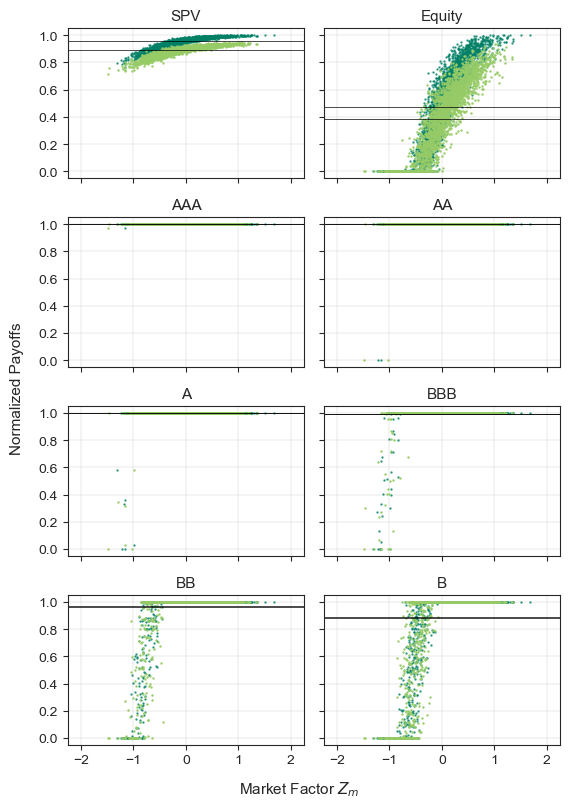

In [107]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=scatter_data['Market Factor'], y = scatter_data[tranche], s= 0.5, color=palette(1),alpha=0.75)
    axs[i,j].scatter(x=scatter_data2['Market Factor'], y = scatter_data2[tranche], s= 0.5, color=palette(150))
    axs[i,j].set_title(tranche, size=11)
    
    axs[i,j].axhline(scatter_data[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    axs[i,j].axhline(scatter_data2[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    
    axs[i,j].set_xlabel('')
    axs[i,j].set_xlim([-2.25,2.25])
    axs[i,j].set_xticks([-2,-1,0,1,2])
    
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 20*cm)
fig.tight_layout()

#fig.savefig("Payoffs.pdf", bbox_inches='tight', format='pdf')

plt.show()

In [108]:
initial_market_value_prepayment = mv_call * J

In [172]:
prepay_tab = DefTable[[ttm]].copy()
prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
prepay_tab['Face Value'] = (np.quantile(pp_SPV_P, prepay_tab['Default Probability']/100) / initial_market_value) * 100
prepay_tab

,Default Probability,Face Value
AAA,0.27,96.597890
AA,0.30,97.044437
A,0.46,98.695215
BBB,1.54,103.504729
BB,6.43,109.388038
B,17.35,113.630670


In [167]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value_prepayment * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 134.22


In [173]:
for rating in prepay_tab.index:
    prepay_tab.loc[rating, 'Market Value'] = (np.minimum(pp_SPV_Q,
                                                         np.quantile(pp_SPV_P,
                                                                     prepay_tab.loc[rating, 'Default Probability']/100
                                                                    )).mean() * np.exp(-rf*ttm) / initial_market_value) * 100

Preliminary table before tranching

In [174]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value
AAA,0.27,96.60,80.90
AA,0.30,97.04,81.26
A,0.46,98.70,82.57
BBB,1.54,103.50,86.21
BB,6.43,109.39,90.05
B,17.35,113.63,92.08


Tranching

In [175]:
prepay_tab.loc[:,'Face Value':'Market Value'] = prepay_tab.loc[:,'Face Value':'Market Value'] - prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
prepay_tab.loc['AAA','Face Value'] = (np.quantile(pp_SPV_P, prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value) * 100
prepay_tab.loc['AAA','Market Value'] = (np.minimum(pp_SPV_Q, np.quantile(pp_SPV_P, prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value) * 100
prepay_tab['Yield'] = ott.zero_yield(prepay_tab['Market Value'], prepay_tab['Face Value'], ttm) * 100
prepay_tab.loc['Equity','Market Value'] = 100 - prepay_tab['Market Value'].sum(axis=0)

In [176]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,96.60,80.90,3.55
AA,0.30,0.45,0.36,4.43
A,0.46,1.65,1.31,4.63
BBB,1.54,4.81,3.65,5.54
BB,6.43,5.88,3.84,8.53
B,17.35,4.24,2.02,14.80
Equity,NaN,NaN,7.92,NaN


Comparison with no prepayment case

In [331]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


In [189]:
yields_xy = ott.zero_yield(prepay_tab[['Market Value']].to_numpy() ,no_prepay_tab[['Face Value']].to_numpy() ,ttm) * 100
yields_lol = ott.zero_yield(no_prepay_tab[['Market Value']].to_numpy() ,no_prepay_tab[['Face Value']].to_numpy() ,ttm) * 100

In [196]:
yields_xy-rf*100

array([[ 1.42145328],
       [ 1.77296319],
       [ 2.82432855],
       [ 3.30528893],
       [ 6.47152017],
       [12.68452523],
       [        nan]])

In [190]:
rating_mispricing = yields_xy-yields_lol

In [191]:
rating_mispricing

array([[1.37145874],
       [0.79277126],
       [1.6376579 ],
       [1.19886809],
       [1.33710006],
       [1.18775028],
       [       nan]])

<AxesSubplot:ylabel='Probability'>

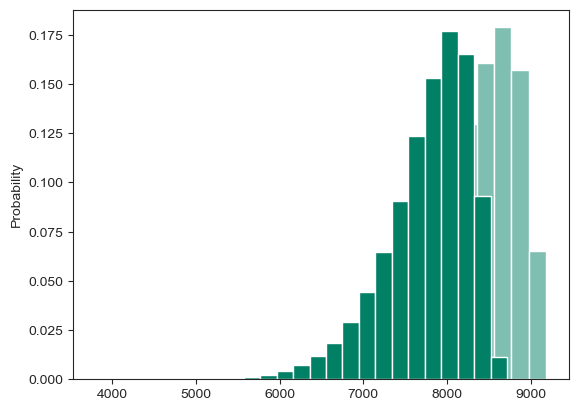

In [264]:
sns.histplot(data=SPV_Q, bins=25, color=palette(1), stat='probability', alpha=0.5)
sns.histplot(data=pp_SPV_Q, bins=25, color=palette(1), stat='probability', alpha=1)